В качестве домашнего задания мы предлагаем вам решить задачу бинарной классификации на большом корпусе imdb рецензий на фильмы. 
Корпус можно скачать по ссылке http://ai.stanford.edu/~amaas/data/sentiment/


1. Ваша задача в sklearn, используя один из алгоритмов, рассмотренных на паре, построить и обучить классификатор, посчитать метрики качества, построить ROC кривую и посчитайте величину ROC AUC.  - **4 балла**


2. Используя предсказания вероятностей класса, найдите 15 самых негативных и самых позитивных рецензий по мнению модели.  - **3 балла**


3. Написать свои функции, которые бы считали tp, fp, tn, fn, и возвращали точность, полноту и ф-меру и применить их к результатам, полученным вашими классификаторами (если все сделано правильно, то результаты должны совпадать с полученными  sklearn метриками). - **3 балла**

Дедлайн - 11 октября 23:59


### Создание датасета

In [1]:
import os
import re
import pandas as pd

In [2]:
tr_pos = []
tr_neg = []
tr_else = []


def read_files(filename, source):
    with open(filename, "r", encoding='utf-8') as file:
        content = file.read()
        source.append(content)
        

for dirpath, dirnames, filenames in os.walk("."):
    if dirpath == './aclImdb/train/pos':
        for filename in filenames:
            read_files(os.path.join(dirpath, filename), tr_pos)
    if dirpath == './aclImdb/train/neg':
        for filename in filenames:
            read_files(os.path.join(dirpath, filename), tr_neg)
    if dirpath == './aclImdb/train/unsup':
        for filename in filenames:
            read_files(os.path.join(dirpath, filename), tr_else)

In [3]:
tr_pos_df = pd.DataFrame(tr_pos, columns=['text'])
tr_pos_df['sourse'] = 'pos'

tr_neg_df = pd.DataFrame(tr_neg, columns=['text'])
tr_neg_df['sourse'] = 'neg'


# задача бинарной классификации --> игнорируем, т. к. тут без метки

oth_df = pd.DataFrame(tr_else, columns=['text'])
oth_df['sourse'] = 'unsup'

In [4]:
te_pos = []
te_neg = []


for dirpath, dirnames, filenames in os.walk("."):
    if dirpath == './aclImdb/test/pos':
        for filename in filenames:
            read_files(os.path.join(dirpath, filename), te_pos)
    if dirpath == './aclImdb/test/neg':
        for filename in filenames:
            read_files(os.path.join(dirpath, filename), te_neg)

In [5]:
te_pos_df = pd.DataFrame(te_pos, columns=['text'])
te_pos_df['sourse'] = 'pos'

te_neg_df = pd.DataFrame(te_neg, columns=['text'])
te_neg_df['sourse'] = 'neg'

In [6]:
train = pd.concat([tr_pos_df, tr_neg_df], ignore_index=True)

In [7]:
train.head()

,text,sourse
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [8]:
train['sourse'].value_counts()

pos    12500
neg    12500
Name: sourse, dtype: int64

In [9]:
test = pd.concat([te_pos_df, te_neg_df], ignore_index=True)

In [10]:
test.head()

,text,sourse
0,"Based on an actual story, John Boorman shows t...",pos
1,This is a gem. As a Film Four production - the...,pos
2,"I really like this show. It has drama, romance...",pos
3,This is the best 3-D experience Disney has at ...,pos
4,"Of the Korean movies I've seen, only three had...",pos


In [11]:
test['sourse'].value_counts()

pos    12500
neg    12500
Name: sourse, dtype: int64

### Классификатор

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [14]:
new_ind = []

for index, row in train.iterrows():
    s = row.sourse
    if s == 'pos':
        ind = 1
        new_ind.append(ind)
    else:
        ind = 0
        new_ind.append(ind)

In [15]:
train['bin_class'] = new_ind

In [16]:
train.head()

,text,sourse,bin_class
0,For a movie that gets no respect there sure ar...,pos,1
1,Bizarre horror movie filled with famous faces ...,pos,1
2,"A solid, if unremarkable film. Matthau, as Ein...",pos,1
3,It's a strange feeling to sit alone in a theat...,pos,1
4,"You probably all already know this by now, but...",pos,1


In [17]:
new_ind_test = []

for index, row in test.iterrows():
    s = row.sourse
    if s == 'pos':
        ind = 1
        new_ind_test.append(ind)
    else:
        ind = 0
        new_ind_test.append(ind)

In [18]:
test['bin_class'] = new_ind_test

In [19]:
test.head()

,text,sourse,bin_class
0,"Based on an actual story, John Boorman shows t...",pos,1
1,This is a gem. As a Film Four production - the...,pos,1
2,"I really like this show. It has drama, romance...",pos,1
3,This is the best 3-D experience Disney has at ...,pos,1
4,"Of the Korean movies I've seen, only three had...",pos,1


#### tf-idf + логистическая регрессия

In [20]:
# делаем tf-idf векторизацию для теста и трейна

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train.text)
X_test_tfidf = tfidf_vectorizer.transform(test.text)
X_train = X_train_tfidf
X_test = X_test_tfidf

In [21]:
# построение и обучение классификатора

model = LogisticRegression().fit(
    X_train, train.bin_class)

y_pred = model.predict(X_test)

/Users/macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
print(classification_report(test.bin_class, y_pred))

print(f'Accuracy: {accuracy_score(test.bin_class, y_pred)}')

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Accuracy: 0.88312


In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [24]:
acc = accuracy_score(test.bin_class, y_pred)
rcall = recall_score(test.bin_class, y_pred)
prc = precision_score(test.bin_class, y_pred)
f_1 = f1_score(test.bin_class, y_pred)



# в семинаре еще были micro и macro,
# но у нас задача бинарной классификации,
# поэтому я решила не использовать это
# и ограничиться стандарнтными метриками

Вывод метрик: 

In [25]:
print('acc={0:1.4f}'.format(acc))
print('recall={0:1.4f}'.format(rcall))
print('precision={0:1.4f}'.format(prc))
print('F_1 score={0:1.4f}'.format(f_1))

acc=0.8831
recall=0.8818
precision=0.8841
F_1 score=0.8830


#### pipeline countvectorizer + tf-idf + логистическая регрессия. 


Можно и так, но мне не очень понравился такой вариант, потому что точность заметно ниже, чем просто на tf-idf + логистическая регрессия. Но такой вариант я пробовала тоже, поэтому оставляю его в этой тетрадке, но дальше анализировать (в оставльных заданиях) его не буду (приведу просто для сравнения метрик).

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf = Pipeline([('vect', CountVectorizer(ngram_range = (2, 3))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf', LogisticRegression())])

In [27]:
text_clf.fit(train.text, train.bin_class)  
predicted = text_clf.predict(test.text)

/Users/macbook/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [28]:
print(classification_report(test.bin_class, predicted))

print(f'Accuracy: {accuracy_score(test.bin_class, predicted)}')

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     12500
           1       0.86      0.87      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy: 0.86408


In [29]:
acc_1 = accuracy_score(test.bin_class, predicted)
rcall_1 = recall_score(test.bin_class, predicted)
prc_1 = precision_score(test.bin_class, predicted)
f_1_2 = f1_score(test.bin_class, predicted)
print('acc={0:1.4f}'.format(acc_1))
print('recall={0:1.4f}'.format(rcall_1))
print('precision={0:1.4f}'.format(prc_1))
print('F_1 score={0:1.4f}'.format(f_1_2))

acc=0.8641
recall=0.8712
precision=0.8590
F_1 score=0.8650


#### ROC

In [30]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

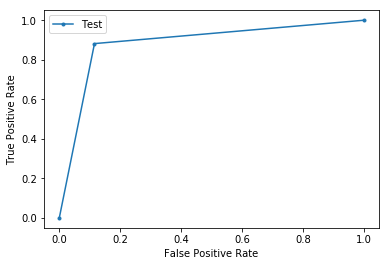

In [31]:
# ROC-кривая

y_true = np.array(test.bin_class)
y_predicted = np.array(y_pred)
fpr, tpr, thrhld = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

In [32]:
print('ROC-AUC: ',
      roc_auc_score(y_true, y_predicted))

ROC-AUC:  0.8831199999999999


### Самые позитиные и самые негативные рецензии

In [33]:
# предсказываем для каждого класса: 0/1

top = model.predict_proba(X_test)

In [34]:
top

array([[0.45095969, 0.54904031],
       [0.27281965, 0.72718035],
       [0.47527185, 0.52472815],
       ...,
       [0.64497376, 0.35502624],
       [0.60355447, 0.39644553],
       [0.62888154, 0.37111846]])

In [35]:
top_0 = []  # значения класса 0
top_1 = []  # значения класса 1

for el in list(top):
    top_0.append(el[0])
    top_1.append(el[1])

In [36]:
test['top_0'] = list(top_0)
test['top_1'] = list(top_1)

In [37]:
test.head()

,text,sourse,bin_class,top_0,top_1
0,"Based on an actual story, John Boorman shows t...",pos,1,0.450960,0.549040
1,This is a gem. As a Film Four production - the...,pos,1,0.272820,0.727180
2,"I really like this show. It has drama, romance...",pos,1,0.475272,0.524728
3,This is the best 3-D experience Disney has at ...,pos,1,0.301777,0.698223
4,"Of the Korean movies I've seen, only three had...",pos,1,0.220779,0.779221


In [38]:
test_top_0 = test.sort_values(['top_0'], ascending=[False])
test_top_1 = test.sort_values(['top_1'], ascending=[False])

In [39]:
texts_neg = test_top_0.head(15).text.tolist()
texts_pos = test_top_1.head(15).text.tolist()

In [40]:
print('ТОП-15 негативных рецензий: \n\n---------\n')

cnt = 1
for el in texts_neg:
    print(cnt, el, '\n')
    cnt += 1

ТОП-15 негативных рецензий: 

---------

1 This was truly horrible. Bad acting, bad writing, bad effects, bad scripting, bad camera shots, bad filming, bad characters, bad music, bad editing, bad casting, bad storyline, bad ... well, you get the idea. It was just, just ... what's the word? Oh yeah ... BAD! 

2 As you can tell from the other comments, this movie is just about the WORST film ever made. Let me see how many different words I can use to describe it: Boring, Unbearable, Laughable, Lousy, Stupid, Horrible.....<br /><br />I could go on with such descriptions but you probably get the point.<br /><br />I would have given this a 0, if possible--bad acting, bad directing, bad production, bad plot.<br /><br />This was made in 2001 and it looks more like 1965. Very low budget, boring plot, horrible acting, really bad special effects, etc...<br /><br />I rarely ever see a Sci-Fi film I absolutely think is this bad. I mean this is pure garbage. It has nothing going for it either. As f

In [41]:
print('ТОП-15 позитивных рецензий: \n\n---------\n')

cnt_2 = 1
for el in texts_pos:
    print(cnt_2, el, '\n')
    cnt_2 += 1

ТОП-15 позитивных рецензий: 

---------

1 What a wonderful film, filled with eccentric, unique characters who are wonderfully realized by a great ensemble cast. The director also did a great job keeping the story held together, getting those wonderful performances (on not messing with them) and using music (and what wonderful music it is) to great effect. S. Epatha in the lead role is great. I had always heard what a brilliant stage actor she is, and although I have enjoyed her on Law and Order, this really shows what she can do with a filled out, complex role. Macy Gray is terrific, Mos Def, as usual, wonderful. Lou Gossett, great. Jimmy Smits, terrific, and doesn't try to pull focus because he's a star. A true piece of ensemble acting. <br /><br />Rent it, enjoy it, groove to it, and treasure it. Something special. 

2 I think this is one of the best tamil movies i've seen in a while. i love the fact that it doesn't revolve around a guy and girl falling in love and they made the mov

### Функции

для сравнения был выбран классификатор tf-idf + логистическая регрессия

In [42]:
test['prediction'] = list(y_pred)

In [43]:
test.head()

,text,sourse,bin_class,top_0,top_1,prediction
0,"Based on an actual story, John Boorman shows t...",pos,1,0.450960,0.549040,1
1,This is a gem. As a Film Four production - the...,pos,1,0.272820,0.727180,1
2,"I really like this show. It has drama, romance...",pos,1,0.475272,0.524728,1
3,This is the best 3-D experience Disney has at ...,pos,1,0.301777,0.698223,1
4,"Of the Korean movies I've seen, only three had...",pos,1,0.220779,0.779221,1


Про значения я читала вот *[тут](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0%D1%85_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8)* и вот *[тут](http://www.machinelearning.ru/wiki/images/archive/5/54/20151001171442%21Kitov-ML-05-Model_evaluation.pdf)*

In [44]:
def tp_func(test):
    return test[(test.bin_class == 1) & (test.prediction == 1)]


def fp_func(test):
    return test[(test.bin_class == 0) & (test.prediction == 1)]


def tn_func(test):
    return test[(test.bin_class == 0) & (test.prediction == 0)]


def fn_func(test):
    return test[(test.bin_class == 1) & (test.prediction == 0)]

In [45]:
tp = tp_func(test).shape[0]
fp = fp_func(test).shape[0]
tn = tn_func(test).shape[0]
fn = fn_func(test).shape[0]

In [46]:
# точность

def accuracy_f(tp, tn, fp, fn):
    func = (tp + tn) / (
        tp + tn + fp + fn)
    return round(func, 4), func 

In [47]:
acc_sc = accuracy_f(tp, tn, fp, fn)[1]
acc_sc_rnd = accuracy_f(tp, tn, fp, fn)[0]

In [48]:
print(acc_sc, '\n', acc_sc_rnd)

0.88312 
 0.8831


In [49]:
# точность 2

def precision_f(tp, fp):
    func = tp / (tp + fp)
    return round(func, 4), func

In [50]:
prec = precision_f(tp, fp)[1]
prec_rnd = precision_f(tp, fp)[0]

In [51]:
print(prec, '\n', prec_rnd)

0.8841033044594161 
 0.8841


In [52]:
# полнота

def recall_f(tp, fn):
    func = tp / (tp + fn)
    return round(func, 4), func

In [53]:
rec = recall_f(tp, fn)[1]
rec_rnd = recall_f(tp, fn)[0]

In [54]:
print(rec, '\n', rec_rnd)

0.88184 
 0.8818


In [55]:
# f мера

def f_m(tp, fn, fp):
    func = 2 / ((1 / precision_f(tp, fp)[1]) + (1 / recall_f(tp, fn)[1]))
    return round(func, 4), func

In [56]:
f_sc = f_m(tp, fn, fp)[1]
f_sc_rnd = f_m(tp, fn, fp)[0]

In [57]:
print(f_sc, '\n', f_sc_rnd)

0.8829702018583787 
 0.883


Все выводы получаются такими же, как и в выбранном классификаторе: tf_idf + логистическая регрессия

In [58]:
print('Результаты sklearn: \n\n------\n')
print('acc={0:1.4f}'.format(acc))
print('recall={0:1.4f}'.format(rcall))
print('precision={0:1.4f}'.format(prc))
print('F_1 score={0:1.4f}'.format(f_1))

Результаты sklearn: 

------

acc=0.8831
recall=0.8818
precision=0.8841
F_1 score=0.8830


In [59]:
print('Результаты на выводе функций: \n\n------\n')
print('acc={0:1.4f}'.format(acc_sc))
print('recall={0:1.4f}'.format(rec))
print('precision={0:1.4f}'.format(prec))
print('F_1 score={0:1.4f}'.format(f_sc))

Результаты на выводе функций: 

------

acc=0.8831
recall=0.8818
precision=0.8841
F_1 score=0.8830
